<a href="https://colab.research.google.com/github/Echo9k/3-potential_talents/blob/dev/Potential%20Talent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Standard libraries
import re
import os
import random
import zipfile as zf
from collections import Counter

# Data manipulation
import pandas as pd
import numpy as np

# Natural Language Processing (NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Machine Learning and vectorization
import torch
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Geolocation
from geopy.geocoders import Nominatim

# Pretrained models and Gensim utilities
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import get_tmpfile
import gensim.downloader as api
from sentence_transformers import SentenceTransformer, util
from transformers import (AutoModel, AutoTokenizer, BertForMaskedLM, Trainer,
                          TrainingArguments, DataCollatorForLanguageModeling,
                          BertTokenizer, BertModel)

# Fuzzy string matching
from fuzzywuzzy import fuzz

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Utilities
from IPython.display import Markdown, display
import wget
from datasets import Dataset

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
wget.download('http://nlp.stanford.edu/data/glove.6B.zip')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


'glove.6B (1).zip'

#### This project is about how to predict fit the candidate is based on their available information.

### Importing Librariers

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = "/content/drive/MyDrive/wdir/repos/Apziva/3-potential_talents/"
    os.getcwd()

except ImportError:
    while 'potential_talents' not in os.listdir('.'):
        os.chdir('..')
        root_dir=os.getcwd()


%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/wdir/repos/Apziva/3-potential_talents


'/content/drive/MyDrive/wdir/repos/Apziva/3-potential_talents'

In [5]:
df = pd.read_csv("data/raw/data.csv",
                 usecols=["job_title", "location", "connection"],
                 converters={"connection":lambda x: 501 if x.strip() == '500+'
                 else int(x.strip() if x.strip().isdigit() else x)})

# Downcast the connection
df["connection"] = pd.to_numeric(df["connection"], downcast="integer")
SEED=42
df.sample(5, random_state=SEED)

,job_title,location,connection
30,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
65,Experienced Retail Manager and aspiring Human ...,"Austin, Texas Area",57
64,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",501
53,Student at Chapman University,"Lake Forest, California",2
45,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   job_title   104 non-null    object
 1   location    104 non-null    object
 2   connection  104 non-null    int16 
dtypes: int16(1), object(2)
memory usage: 2.0+ KB


In [7]:
print(f"The data shape is {df.shape}")
display(Markdown("#### Numeric"),
        df.describe(include="number").round(2))
display(Markdown("#### Object"),
        df.describe(include="object"))

The data shape is (104, 3)


#### Numeric

,connection
count,104.00
mean,263.09
std,223.06
min,1.00
25%,47.00
50%,193.00
75%,501.00
max,501.00


#### Object

,job_title,location
count,104,104
unique,52,41
top,2019 C.T. Bauer College of Business Graduate (...,Kanada
freq,7,12


potentially we have skewness in the number of connections

In [8]:
# plot the connection distributions
fig = px.histogram(df, x="connection", nbins=20,
                   title="Distribution of Connections")
fig.show()

Some applicants might have applied twice. Let's see how many and drop them.

In [9]:
display(df[df.duplicated(keep=False)].sample(3))

## Dropping the duplicated rows
df = df.drop_duplicates().reset_index(drop=True)
print("Shape fo non-duplicated dataframe:", df.shape)

df=df.reset_index(drop=True)
print("New shape: ",df.shape)

,job_title,location,connection
50,HR Senior Specialist,San Francisco Bay Area,501
8,Student at Humber College and Aspiring Human R...,Kanada,61
63,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",501


Shape fo non-duplicated dataframe: (53, 3)
New shape:  (53, 3)


In [10]:
df.job_title.value_counts().head()

,count
job_title,
Aspiring Human Resources Professional,2
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,1
Lead Official at Western Illinois University,1
Senior Human Resources Business Partner at Heil Environmental,1
Aspiring Human Resources Professional | An energetic and Team-Focused Leader,1


In [11]:
def calculate_word_frequencies(column):
    """
    Calculate word frequencies in a pandas column using vectorized operations.

    Parameters:
        column (pd.Series): The column containing text data.

    Returns:
        Counter: A Counter object with word frequencies.
    """
    # Split all text into words using a vectorized join and split approach
    all_words = " ".join(column).split()
    # Count word frequencies
    word_counts = Counter(all_words)
    return word_counts

# Apply the function
word_counts = calculate_word_frequencies(df["job_title"])

# Print results
print("Number of total words:", len(word_counts))
print(word_counts.most_common()[:10])

Number of total words: 221
[('Human', 34), ('Resources', 29), ('at', 22), ('and', 13), ('Aspiring', 11), ('|', 10), ('Professional', 7), ('in', 6), ('University', 6), ('Seeking', 6)]


In [12]:
df.location.value_counts().head()

,count
location,
"Houston, Texas Area",4
"Raleigh-Durham, North Carolina Area",3
Greater New York City Area,3
"Austin, Texas Area",2
Amerika Birleşik Devletleri,2


# Step 1: Modeling Framework

## 1. Data Preprocessing & Feature Engineering

### Cleaning the data

    * Removing special character
    * Writting the text in lower case
    * Removing stopwords and applying lemmatization
    

**Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .**

In [13]:
## Removing special character
df["job_title"] = df["job_title"].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [14]:
df.head().to_markdown()

'|    | job_title                                                                                            | location                            |   connection |\n|---:|:-----------------------------------------------------------------------------------------------------|:------------------------------------|-------------:|\n|  0 | 2019 CT Bauer College of Business Graduate Magna Cum Laude and aspiring Human Resources professional | Houston, Texas                      |           85 |\n|  1 | Native English Teacher at EPIK English Program in Korea                                              | Kanada                              |          501 |\n|  2 | Aspiring Human Resources Professional                                                                | Raleigh-Durham, North Carolina Area |           44 |\n|  3 | People Development Coordinator at Ryan                                                               | Denton, Texas                       |          501 |\n|  4 | Advisory

In [15]:
df["job_title"] =df["job_title"].str.lower()
df["location"]=df["location"].str.lower()

In [16]:
# Initialize reusable objects
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
detokenizer = TreebankWordDetokenizer()


def clean_text_vectorized(text):
    # Check if text is a valid string; otherwise, return an empty string
    if not isinstance(text, str) or not text.strip():
        return ""

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    mask = np.isin(tokens, list(stop_words), invert=True)
    filtered_tokens = np.array(tokens)[mask]

    # Lemmatize
    lemmatized_tokens = np.vectorize(lemmatizer.lemmatize)(filtered_tokens)

    # Detokenize
    return detokenizer.detokenize(lemmatized_tokens)


def cleaning(df, col=None, inplace=False):
    """
    Cleans the specified column(s) of the DataFrame by applying the clean_text_vectorized function.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        col (str or list): The column name or list of column names to clean.
        inplace (bool): Whether to modify the original DataFrame or return a new one.

    Returns:
        pd.DataFrame or None: If inplace is False, returns a modified DataFrame; otherwise, modifies the input DataFrame in place and returns None.
    """
    if col is None:
        raise ValueError("You must specify at least one column name to clean.")

    # If inplace is False, create a copy of the DataFrame to modify
    if not inplace:
        df = df.copy()

    # Process the column(s)
    if isinstance(col, str):  # Single column case
        df[col] = df[col].apply(lambda x: clean_text_vectorized(x) if pd.notna(x) else x)
    elif isinstance(col, list):  # Multiple columns case
        df[col] = df[col].map(lambda x: clean_text_vectorized(x) if pd.notna(x) else x)
    else:
        raise TypeError("col must be a string or a list of strings.")

    # If inplace is True, the original DataFrame is modified
    if inplace:
        return None
    else:
        return df[col]


In [17]:
print("Job title before removing stopwords:\n", df.job_title.head(1))
print("-"*90)

df[["location", "job_title"]] = cleaning(df, ["location", "job_title"])

print("Job title after removing stopwords:\n", df.job_title.head(1))
print("-"*90)
df.sample(3, random_state=SEED)

Job title before removing stopwords:
 0    2019 ct bauer college of business graduate mag...
Name: job_title, dtype: object
------------------------------------------------------------------------------------------
Job title after removing stopwords:
 0    2019 ct bauer college business graduate magna ...
Name: job_title, dtype: object
------------------------------------------------------------------------------------------


,job_title,location,connection
19,human resource generalist scottmadden inc,"raleigh-durham, north carolina area",501
41,admission representative community medical cen...,"long beach, california",9
47,seeking human resource position,"la vega, nevada area",48


Cleaning and standardizing the job_title column by replacing abbreviations and specific terms with their full forms. This makes the data more consistent and easier to analyze.

In [18]:
# lookup table
dir_replacements_job_title = {
    'chro' : 'chief human resources officer',
    'svp' : 'senior vice president',
    'gphr' : 'global professional in human resources',
    'hris' : 'human resources management system',
    'csr' : 'corporate social responsibility',
    'sphr' : 'strategic and policy-making certification',
    'hr' : 'human resources', "[\'!#)$%&(*+-./:;<=>?@[\]^_`{|}~\n]" : "",
    r'[0-9]' : '', 'epik' : 'tech',
    'styczynski lab' : 'tech', 'gi' : 'tech', "schwan's" : 'tech',
    'ryan' : 'not tech', 'engine' : 'not tech', 'buckhead atlanta' : 'not tech',
    'loparex' : 'not tech', 'delphi Hardware' : 'not tech', "jti" : 'not tech',
    'traveler' : 'not tech', 'luxottica' : 'not tech', 'beneteau' : 'not tech',
    'scottMadden' : 'not tech', 'ey' : 'not tech', 'endemol' : 'not tech',
    'nortia staffing' : 'not tech', 'heil environmental' : 'not tech',
    'excellence logging' : 'not tech'
    }

## Replace the abbreviation with their description
df = df.replace({'job_title' : dir_replacements_job_title}, regex=True)

In [19]:
assert df.shape[0] > 50

# Paso 1: Definir el Marco de Modelado

## 1.1 Preprocesamiento de Datos y Generación de Características:

#### Word Embedding Techniques



I will be using 4 different strategies to find the similarties betwen the targeted sentences and each job title as follows

 1. **TF-IDF**(term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

    
  2. **GloVe** stands for global vectors for word representation. It is used for generating word embeddings by aggregating global word-word co-occurrence matrix from a corpus. The resulting embeddings show interesting linear substructures of the word in vector space.
    
   
   3. **Word2Vec** is a technique which produces word embeddings for better word representation. We can also say it consists of models for generating word embedding which are shallow two layer neural networks having one input layer, one hidden layer and one output layer.
    
   
   4. **BERT** It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context.

##### 1. Fuzzy word match

In [20]:
search_phrases = [
    'aspiring human resources',
    'human resources assistant',
    'hr coordinator',
    'hr generalist (entry-level)',
    'talent acquisition assistant',
    'recruitment coordinator',
    'hr intern',
    'hr trainee',
    'junior hr specialist',
    'hr associate',
    'people operations assistant'
    ]

In [21]:
def calculate_keyword_match(df, keyword):
  """Calculates the keyword match using fuzzywuzzy's partial_ratio in a vectorized way.

  Args:
    df: Pandas DataFrame with a 'job_title' column.
    keyword: The keyword to match against.

  Returns:
    A NumPy array containing the partial ratio scores.
  """

  return np.vectorize(lambda x: fuzz.partial_ratio(x.lower(), keyword.lower()))(df['job_title'].values)

# Example usage with your DataFrame and keyword
df['partial_match'] = calculate_keyword_match(df, "aspiring human resources")

In [22]:
# prompt: Let's modify this cell so that partial_match considers all search_phrases

def calculate_keyword_match(df, search_phrases):
    """Calculates the keyword match using fuzzywuzzy's partial_ratio for multiple phrases.

    Args:
    df: Pandas DataFrame with a 'job_title' column.
    search_phrases: A list of keywords to match against.

    Returns:
    A NumPy array containing the maximum partial ratio score for each row.
    """
    if isinstance(search_phrases, str):
        return np.vectorize(lambda x: fuzz.partial_ratio(x.lower(), search_phrases.lower()))
        (df['job_title'].values)

    elif isinstance(search_phrases, list):
        # Find the maximum partial ratio score for each row across all search phrases
        return np.max([
            np.vectorize(lambda x: fuzz.partial_ratio(x.lower(), phrase.lower()))(
                df['job_title'].values) for phrase in search_phrases
        ], axis=0)  # partial_ratios

# Example usage with your DataFrame and keyword list
df['partial_match'] = calculate_keyword_match(df, search_phrases)

##### 2. TF-IDF

In [23]:
## Convert hob titles column into a list
job_title_list =list(df["job_title"])

# Vectorize job_title_list
vectorizer = TfidfVectorizer().fit(job_title_list)
X =vectorizer.transform(job_title_list)

# Get feature names in all the documents
# Use get_feature_names_out() instead of get_feature_names()
feature_names = vectorizer.get_feature_names_out()
print("Number of unique features: ", len(feature_names))
print("First 5 features: ", feature_names[:5])

# convert job titles into array
tfidf_vector = X.toarray()
print("Shape of Tfidf Vector: ", tfidf_vector.shape)

Number of unique features:  167
First 5 features:  ['administration' 'administrative' 'admission' 'advisory' 'always']
Shape of Tfidf Vector:  (53, 167)


In [24]:
def similarity(phrase, vectorizer, tfidf_matrix, df):
    """
    Calculate the similarity of a phrase with a given column in a dataframe using cosine similarity.

    Parameters:
        phrase (list): A list containing the search phrase(s).
        vectorizer (TfidfVectorizer): Fitted TF-IDF vectorizer.
        tfidf_matrix (csr_matrix): TF-IDF matrix of the dataframe's text.
        df (DataFrame): DataFrame to update with similarity scores.
    """

    similarity_scores = []
    for job_title in df["job_title"]:
        # Convert search phrase and job title into vectors
        phrase_vector = vectorizer.transform(phrase)
        job_title_vector = vectorizer.transform([job_title])

        # Calculate cosine similarity and take the maximum for all phrases
        score = max(cosine_similarity(job_title_vector, phrase_vector).flatten())
        similarity_scores.append(score)

    # Return the list of similarity scores
    return similarity_scores

In [25]:
# Example DataFrame and setup
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["job_title"])

# Call the similarity function
df["similarity_score"] = similarity(search_phrases, vectorizer, tfidf_matrix, df)

# View the DataFrame
df.sample(3, random_state=SEED)

,job_title,location,connection,partial_match,similarity_score
19,human resource generalist scottmadden inc,"raleigh-durham, north carolina area",501,76,0.446244
41,admission representative community medical cen...,"long beach, california",9,56,0.000000
47,seeking human resource position,"la vega, nevada area",48,79,0.096089


In [26]:
# Searched prhase
phrases = pd.DataFrame({"phrase":search_phrases})
cleaning(phrases, "phrase")

,phrase
0,aspiring human resource
1,human resource assistant
2,hr coordinator
3,hr generalist (entry-level)
4,talent acquisition assistant
5,recruitment coordinator
6,hr intern
7,hr trainee
8,junior hr specialist
9,hr associate


In [27]:
# Assuming cleaning is defined and does what it needs to do
cleaning(phrases, "phrase")

# Call the similarity function with all required arguments
df["TF-IDF_fit_score"] = similarity([phrases.phrase[0]],
                                    vectorizer, tfidf_matrix, df)
df.sort_values(by ="TF-IDF_fit_score", ascending=False).head(3)

,job_title,location,connection,partial_match,similarity_score,TF-IDF_fit_score
7,human resources senior specialist,san francisco bay area,501,81,0.500978,0.500978
2,aspiring human resource professional,"raleigh-durham, north carolina area",44,96,0.430994,0.430994
45,aspiring human resource professional,"kokomo, indiana area",71,96,0.430994,0.430994


##### 3. GloVe

In [28]:
files = zf.ZipFile("glove.6B.zip", 'r')
files.extractall('GloVe')
files.close()

In [29]:
# Create temp file and save converted embedding into it
target_file = get_tmpfile("word2vec.6B.50d.txt")
glove2word2vec("GloVe/glove.6B.50d.txt", target_file)

# Load the converetd embedding into memory
glove_model = KeyedVectors.load_word2vec_format(target_file)

# Save as binary data
glove_model.save_word2vec_format('word2vec.6B.50d.bin.gz', binary=True)

<ipython-input-29-55d19389335a>:3: DeprecationWarning:

Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).



In [30]:
def doc_token_vectors(sentence, model, vector_dimensions):
    """
    Generate token vectors for a sentence using the provided model.

    Args:
        sentence (str): The input sentence.
        model (gensim.models.KeyedVectors): The word embedding model.
        vector_dimensions (int): The dimensionality of the word embeddings.

    Returns:
        np.ndarray: A 2D numpy array where each row represents a token vector.
    """
    # Tokenize the sentence
    word_tokens = np.array(word_tokenize(sentence))

    # Create a mask for words present in the model's vocabulary
    mask = np.array([word in model for word in word_tokens])

    # Initialize an array of zeros for all token vectors
    sentence_vectors = np.zeros((len(word_tokens), vector_dimensions))

    # If there are words in the model, retrieve their vectors
    if mask.any():
        words_in_model = word_tokens[mask]
        # Retrieve vectors for all words at once
        sentence_vectors[mask] = model[words_in_model]

    return sentence_vectors

def model_fitt_score(Series, model, ndimensions, *, phrase):
    """
    Calculate similarity scores between job titles and a search phrase using word embeddings.

    Args:
        df (pandas.DataFrame): The DataFrame containing job titles.
        col (str): The column with data to fit.
        model (gensim.models.KeyedVectors): The word embedding model.
        ndimensions (int): The dimensionality of the word embeddings.
        phrase (str): The search phrase.
        fitt_col_name (str): The name of the column to store similarity scores.
    """
    # Helper function to compute the mean vector of a sentence
    def sentence_mean_vector(sentence):
        # Tokenize the sentence and retrieve vectors for known words
        word_tokens = np.array(word_tokenize(sentence))
        mask = np.array([word in model for word in word_tokens])
        if mask.any():
            words_in_model = word_tokens[mask]
            # Retrieve vectors for all words at once
            word_vectors = model[words_in_model]
            # Compute the mean vector
            return np.mean(word_vectors, axis=0)
        else:
            # Return a zero vector if no words are in the model
            return np.zeros(ndimensions)

    # Compute mean vectors for all job titles using vectorization
    mean_vector = Series.map(sentence_mean_vector)

    # Compute the mean vector for the search phrase
    search_phrase_mean_vector = sentence_mean_vector(phrase).reshape(1, -1)

    # Stack the mean vectors into a 2D NumPy array
    mean_vectors = np.vstack(mean_vector.values)

    # Compute cosine similarities in a vectorized manner
    return cosine_similarity(mean_vectors, search_phrase_mean_vector).flatten()

In [31]:
df['GloVe_fit_score'] = model_fitt_score(
    df['job_title'],
    glove_model, 50,
    phrase=phrases.phrase[0]
    )
display(Markdown("### Head"), Markdown("---"),
df.sort_values(by="GloVe_fit_score", ascending=False).head(7))
display(Markdown("### Tail"), Markdown("---"),
df.sort_values(by="GloVe_fit_score", ascending=False).tail(7))

### Head

---

,job_title,location,connection,partial_match,similarity_score,TF-IDF_fit_score,GloVe_fit_score
5,aspiring human resource specialist,greater new york city area,1,96,0.454403,0.374845,0.939268
2,aspiring human resource professional,"raleigh-durham, north carolina area",44,96,0.430994,0.430994,0.931925
45,aspiring human resource professional,"kokomo, indiana area",71,96,0.430994,0.430994,0.931925
21,aspiring human resource manager seeking intern...,"houston, texas area",7,96,0.300153,0.300153,0.924779
24,aspiring human resource professional passionat...,"new york, new york",212,96,0.143062,0.143062,0.923646
22,human resource professional,greater boston area,16,76,0.140331,0.140331,0.914959
13,seeking human resource opportunity,"chicago, illinois",390,79,0.092903,0.092903,0.912576


### Tail

---

,job_title,location,connection,partial_match,similarity_score,TF-IDF_fit_score,GloVe_fit_score
46,student,"houston, texas area",4,71,0.0,0.0,0.604048
39,lead official western illinois university,greater chicago area,39,56,0.0,0.0,0.587198
35,bachelor science biology victoria university w...,"baltimore, maryland",40,58,0.0,0.0,0.536258
43,student westfield state university,"bridgewater, massachusetts",57,47,0.0,0.0,0.529761
44,student indiana university kokomo business man...,"lafayette, indiana",19,56,0.0,0.0,0.529341
9,student chapman university,"lake forest, california",2,47,0.0,0.0,0.526304
4,advisory board member celal bayar university,"i̇zmir, türkiye",501,56,0.0,0.0,0.473900


##### 4.Word2Vec

In [32]:
if "GoogleNews_model" not in globals():
    GoogleNews_model = api.load('word2vec-google-news-300')
df['GoogleNews_fit_score'] = model_fitt_score(
    df['job_title'], GoogleNews_model, 300,
    phrase = phrases.phrase[0]
    )
display(Markdown("### Head"), Markdown("---"),
df.sort_values(by="GoogleNews_fit_score", ascending=False).head(3))
display(Markdown("### Tail"), Markdown("---"),
df.sort_values(by="GoogleNews_fit_score", ascending=False).tail(3))

### Head

---

,job_title,location,connection,partial_match,similarity_score,TF-IDF_fit_score,GloVe_fit_score,GoogleNews_fit_score
2,aspiring human resource professional,"raleigh-durham, north carolina area",44,96,0.430994,0.430994,0.931925,0.872865
45,aspiring human resource professional,"kokomo, indiana area",71,96,0.430994,0.430994,0.931925,0.872865
5,aspiring human resource specialist,greater new york city area,1,96,0.454403,0.374845,0.939268,0.836409


### Tail

---

,job_title,location,connection,partial_match,similarity_score,TF-IDF_fit_score,GloVe_fit_score,GoogleNews_fit_score
46,student,"houston, texas area",4,71,0.0,0.0,0.604048,0.222213
4,advisory board member celal bayar university,"i̇zmir, türkiye",501,56,0.0,0.0,0.473900,0.208822
51,always set success,greater los angeles area,501,42,0.0,0.0,0.675387,0.206629


##### 5. BERT

In [37]:
# build bert_base model
bert_model = SentenceTransformer("bert-base-nli-mean-tokens")

In [38]:
# Convert job title into BERT embedded vectors
bert_job_title_embeddings = bert_model.encode(list(df.job_title))
print("bert_job_title_embeddings: ", bert_job_title_embeddings.shape)

# convert search phrase into a bert embedded vector
bert_search_phrase_embeddings = bert_model.encode(phrases.phrase[0])
print("bert_search_phrase_embeddings: ", bert_search_phrase_embeddings.shape)

bert_job_title_embeddings:  (53, 768)
bert_search_phrase_embeddings:  (768,)


In [39]:
# Convert embeddings to NumPy arrays if they aren't already
bert_job_title_embeddings = np.array(bert_job_title_embeddings)
bert_search_phrase_embeddings = np.array(bert_search_phrase_embeddings)

# Reshape bert_search_phrase_embeddings to 2D if necessary
if len(bert_search_phrase_embeddings.shape) == 1:
    bert_search_phrase_embeddings = bert_search_phrase_embeddings.reshape(1, -1)

# Compute cosine similarities in a vectorized manner
similarities = cosine_similarity(bert_job_title_embeddings, bert_search_phrase_embeddings).flatten()

# Add the similarities to the DataFrame
df["BERT_model_fit_score"] = similarities

In [40]:
def compute_cosine_similarity_in_batches(job_embeddings, search_embedding, batch_size=10000):
    """

    Compute cosine similarity between a search embedding and a set of job embeddings in batches.

    Args:
        job_embeddings (np.ndarray): A 2D numpy array where each row represents a job embedding.
        search_embedding (np.ndarray): A 1D numpy array representing the search embedding.
        batch_size (int): The number of embeddings to process in each

    # Example usage
        similarities = compute_cosine_similarity_in_batches(bert_job_title_embeddings, bert_search_phrase_embeddings)
        df["BERT_model_fit_score"] = similarities

    Returns:
        np.ndarray: A 1D numpy array of cosine similarities.
    """

    num_samples = job_embeddings.shape[0]
    similarities = np.zeros(num_samples)

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_embeddings = job_embeddings[start_idx:end_idx]
        batch_similarities = cosine_similarity(batch_embeddings, search_embedding).flatten()
        similarities[start_idx:end_idx] = batch_similarities

    return similarities

In [41]:
display(Markdown("### Head"), Markdown("---"),
df.sort_values(by="BERT_model_fit_score", ascending=False).head(3))
display(Markdown("### Tail"), Markdown("---"),
df.sort_values(by="BERT_model_fit_score", ascending=False).tail(3))

### Head

---

,job_title,location,connection,partial_match,similarity_score,TF-IDF_fit_score,GloVe_fit_score,GoogleNews_fit_score,BERT_model_fit_score
5,aspiring human resource specialist,greater new york city area,1,96,0.454403,0.374845,0.939268,0.836409,0.950305
45,aspiring human resource professional,"kokomo, indiana area",71,96,0.430994,0.430994,0.931925,0.872865,0.930828
2,aspiring human resource professional,"raleigh-durham, north carolina area",44,96,0.430994,0.430994,0.931925,0.872865,0.930828


### Tail

---

,job_title,location,connection,partial_match,similarity_score,TF-IDF_fit_score,GloVe_fit_score,GoogleNews_fit_score,BERT_model_fit_score
41,admission representative community medical cen...,"long beach, california",9,56,0.0,0.0,0.677400,0.265030,0.192242
33,rrp brand portfolio executive not tech japan t...,greater philadelphia area,501,78,0.0,0.0,0.627995,0.251379,0.160625
35,bachelor science biology victoria university w...,"baltimore, maryland",40,58,0.0,0.0,0.536258,0.273652,0.139689


**Among all of the models, the BERT model gives us a high score for the top rows and a low one for unrelated titles.**


##### SBERT

In [ ]:
display(Markdown("### Head"), Markdown("---"),
df.sort_values(by="BERT_model_fit_score", ascending=False).head(3))
display(Markdown("### Tail"), Markdown("---"),
df.sort_values(by="BERT_model_fit_score", ascending=False).tail(3))

#### Combination of Representations:
Combines dense embeddings (such as Word2Vec/BERT) with TF-IDF. For example, TF-IDF can capture less frequent but critical words, while dense embeddings provide semantic context.

In [53]:
# Aggregating similarity scores using a weighted average
weights = {
    "TF-IDF_fit_score": 0.05,
    "GloVe_fit_score": 0.25,
    "GoogleNews_fit_score": 0.25,
    "BERT_model_fit_score": 0.45,
}

df["similarity_score"] = (
    df["TF-IDF_fit_score"] * weights["TF-IDF_fit_score"]
    + df["GloVe_fit_score"] * weights["GloVe_fit_score"]
    + df["GoogleNews_fit_score"] * weights["GoogleNews_fit_score"]
    + df["BERT_model_fit_score"] * weights["BERT_model_fit_score"]
)
df.sort_values(by="similarity_score", ascending=False).head()

,job_title,location,connection,partial_match,similarity_score,TF-IDF_fit_score,GloVe_fit_score,GoogleNews_fit_score,BERT_model_fit_score,w2v_embedding,glove_embedding,bert_embedding
2,aspiring human resource professional,"raleigh-durham, north carolina area",44,96,0.891620,0.430994,0.931925,0.872865,0.930828,"[-0.0065236343, 0.0038611062, 0.0022791105, 0....","[-0.410595, 0.412165, -0.22257501, 0.15426752,...","[0.054572538, -0.20887633, -0.09158989, 0.0294..."
45,aspiring human resource professional,"kokomo, indiana area",71,96,0.891620,0.430994,0.931925,0.872865,0.930828,"[-0.0065236343, 0.0038611062, 0.0022791105, 0....","[-0.410595, 0.412165, -0.22257501, 0.15426752,...","[0.054572538, -0.20887633, -0.09158989, 0.0294..."
5,aspiring human resource specialist,greater new york city area,1,96,0.890299,0.374845,0.939268,0.836409,0.950305,"[-0.00613855, 0.004391554, 0.003030991, 0.0050...","[-0.090077505, 0.342235, -0.094809994, 0.19769...","[-0.06417197, -0.23510593, 0.00801603, 0.13951..."
30,aspiring human resource professional energetic...,"austin, texas area",174,96,0.810853,0.208973,0.887662,0.776035,0.854400,"[-0.006090722, 0.002101077, 0.0011290895, 0.00...","[-0.28057, 0.33491114, -0.06897167, 0.10725668...","[-0.04760429, -0.2705578, 0.32277986, 0.097200..."
21,aspiring human resource manager seeking intern...,"houston, texas area",7,96,0.793459,0.300153,0.924779,0.822812,0.759009,"[-0.00022555649, 0.0009806997, 0.002329268, 0....","[0.09373249, 0.2754485, -0.1294775, 0.19312938...","[-0.09427112, 0.036055557, 0.31200838, 0.08316..."


## Hybrid Emmbedings

### **1.1. Compute Individual Embeddings**

#### **1.1.1. TF-IDF Embeddings**

In [54]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the job titles
tfidf_matrix = tfidf_vectorizer.fit_transform(df['job_title'])
# Ensure all embeddings have the same length
embedding_dim = 100  # Adjust based on your models

def pad_embedding(embedding, target_dim):
    if len(embedding) < target_dim:
        return np.pad(embedding, (0, target_dim - len(embedding)), 'constant')
    else:
        return embedding[:target_dim]

df['tfidf_embedding'] = list(tfidf_matrix.toarray())


#### **1.1.2. Word2Vec Embeddings**

In [55]:
# Tokenize job titles
tokenized_titles = df['job_title'].apply(nltk.word_tokenize)

# Train Word2Vec model
w2v_model = Word2Vec(tokenized_titles, vector_size=100, window=5, min_count=1, workers=4)

# Get Word2Vec embeddings
def get_w2v_embedding(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

df['w2v_embedding'] = tokenized_titles.apply(get_w2v_embedding)


#### **1.1.3. GloVe Embeddings**

Assuming you have pre-trained GloVe embeddings:

In [56]:
# Load pre-trained GloVe embeddings
glove_model = KeyedVectors.load_word2vec_format("GloVe/glove.6B.50d.txt",
                                                binary=False, no_header=True)

# Get GloVe embeddings
def get_glove_embedding(tokens):
    vectors = [glove_model[word] for word in tokens if word in glove_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(glove_model.vector_size)

df['glove_embedding'] = tokenized_titles.apply(get_glove_embedding)


#### 1.1.4. BERT Embeddings

In [57]:
# Initialize BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Get BERT embeddings
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad(): # Now torch is defined and can be used
        outputs = bert_model(**inputs)
    # Take the mean of the token embeddings
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

df['bert_embedding'] = df['job_title'].apply(get_bert_embedding)

## **2. Sentence Transformers (SBERT)**

Use pre-trained SBERT models for sentence similarity tasks.

In [58]:
# Initialize the SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute SBERT embeddings
df['sbert_embedding'] = df['job_title'].apply(lambda x: sbert_model.encode(x))

### **1.2. Combine Embeddings to Create Hybrid Embeddings**

We'll concatenate the embeddings from different models to form a hybrid embedding.

In [59]:
# Ensure all embeddings have the same length
embedding_dim = 100  # Adjust based on your models

def pad_embedding(embedding, target_dim):
    if len(embedding) < target_dim:
        return np.pad(embedding, (0, target_dim - len(embedding)), 'constant')
    else:
        return embedding[:target_dim]

df['tfidf_embedding'] = list(tfidf_matrix.toarray())

# Pad embeddings if necessary
df['w2v_embedding'] = df['w2v_embedding'].apply(lambda x: pad_embedding(x, embedding_dim))
df['glove_embedding'] = df['glove_embedding'].apply(lambda x: pad_embedding(x, embedding_dim))
df['bert_embedding'] = df['bert_embedding'].apply(lambda x: pad_embedding(x, embedding_dim))

# Combine embeddings
def combine_embeddings(row):
    return np.concatenate([
        row['tfidf_embedding'],
        row['w2v_embedding'],
        row['glove_embedding'],
        row['bert_embedding']
    ])

df['hybrid_embedding'] = df.apply(combine_embeddings, axis=1)


In [60]:
# Prepare dataset
domain_texts = [
    "Ingeniero de software full-stack con experiencia en Python, JavaScript y desarrollo de aplicaciones web.",
    "Gerente de ingeniería con enfoque en liderazgo de equipos y entrega de proyectos tecnológicos.",
    "Especialista en recursos humanos con experiencia en reclutamiento y retención de talento en empresas tecnológicas.",
    "Candidato con habilidades en inteligencia artificial y aprendizaje automático, experiencia trabajando con TensorFlow y PyTorch.",
    "Desarrollador móvil con experiencia en Flutter y React Native, enfocado en diseño y usabilidad.",
    "Analista de datos con habilidades en SQL, Python y herramientas de visualización como Tableau.",
]
dataset = Dataset.from_dict({'text': domain_texts})

# Tokenize dataset
def tokenize_function(examples):
    return bert_tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Initialize the model
bert_mlm_model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# Training arguments
training_args = TrainingArguments(
    output_dir='./bert_finetuned',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=10_000,
    save_total_limit=2,
)

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=bert_tokenizer, mlm=True, mlm_probability=0.15
)

# Trainer
trainer = Trainer(
    model=bert_mlm_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

# Fine-tune the model
trainer.train()

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

Step,Training Loss


TrainOutput(global_step=3, training_loss=3.148655891418457, metrics={'train_runtime': 87.1182, 'train_samples_per_second': 0.207, 'train_steps_per_second': 0.034, 'total_flos': 1184421657600.0, 'train_loss': 3.148655891418457, 'epoch': 3.0})

In [61]:
# Use the fine-tuned model for embeddings
def get_finetuned_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_mlm_model.bert(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

df['finetuned_bert_embedding'] = df['job_title'].apply(get_finetuned_bert_embedding)


## **4. Ensemble Embedding Scoring**

Aggregate similarity scores across multiple embeddings using weighted averages.

### **4.1. Compute Similarity Scores**

Assuming you have a search phrase and you want to compute similarity scores.

In [62]:
search_phrase = "\"Human Resources\"" # @param {"type":"string"}


# Compute embeddings for the search phrase
search_tfidf_vector = tfidf_vectorizer.transform([search_phrase]).toarray()[0]
search_w2v_embedding = get_w2v_embedding(nltk.word_tokenize(search_phrase))
search_glove_embedding = get_glove_embedding(nltk.word_tokenize(search_phrase))
search_bert_embedding = get_bert_embedding(search_phrase)

# Initialize and load the SBERT model
sbert_model = SentenceTransformer('all-mpnet-base-v2')

search_sbert_embedding = sbert_model.encode(search_phrase)
search_finetuned_bert_embedding = get_finetuned_bert_embedding(search_phrase)
search_hybrid_embedding = np.concatenate([
    search_tfidf_vector,
    search_w2v_embedding,
    search_glove_embedding,
    search_bert_embedding
])

### **4.2. Compute Cosine Similarities**

In [64]:
# Find the maximum embedding size for glove_embedding
max_glove_dim = max(len(embedding) for embedding in df['glove_embedding'])

# Pad or truncate embeddings to the same size
def fix_embedding_dim(embedding, target_dim):
    if len(embedding) < target_dim:
        # Pad with zeros
        return np.pad(embedding, (0, target_dim - len(embedding)))
    else:
        # Truncate if too large
        return embedding[:target_dim]

df['glove_embedding'] = df['glove_embedding'].apply(
    lambda x: fix_embedding_dim(x, max_glove_dim)
)

# Ensure search embedding matches the same size
search_glove_embedding = fix_embedding_dim(search_glove_embedding, max_glove_dim)

# Recompute cosine similarity
glove_similarities = cosine_similarity(
    np.vstack(df['glove_embedding'].values.tolist()),
    [search_glove_embedding]
).flatten()
df['glove_similarity'] = glove_similarities


In [66]:
def ensure_consistent_dimensions(df, embedding_column, search_embedding):
    max_dim = max(len(embedding) for embedding in df[embedding_column])
    df[embedding_column] = df[embedding_column].apply(
        lambda x: fix_embedding_dim(x, max_dim)
    )
    search_embedding = fix_embedding_dim(search_embedding, max_dim)
    return df, search_embedding
df, search_glove_embedding = ensure_consistent_dimensions(df, 'glove_embedding', search_glove_embedding)
df, search_w2v_embedding = ensure_consistent_dimensions(df, 'w2v_embedding', search_w2v_embedding)
df, search_bert_embedding = ensure_consistent_dimensions(df, 'bert_embedding', search_bert_embedding)
df, search_sbert_embedding = ensure_consistent_dimensions(df, 'sbert_embedding', search_sbert_embedding)
df, search_finetuned_bert_embedding = ensure_consistent_dimensions(df, 'finetuned_bert_embedding', search_finetuned_bert_embedding)
df, search_hybrid_embedding = ensure_consistent_dimensions(df, 'hybrid_embedding', search_hybrid_embedding)

In [68]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# TF-IDF Similarity
tfidf_similarities = cosine_similarity(
    np.vstack(df['tfidf_embedding'].values.tolist()),
    [search_tfidf_vector]
).flatten()
df['tfidf_similarity'] = tfidf_similarities

# Word2Vec Similarity
w2v_similarities = cosine_similarity(
    np.vstack(df['w2v_embedding'].values.tolist()),
    [search_w2v_embedding]
).flatten()
df['w2v_similarity'] = w2v_similarities

# GloVe Similarity
glove_similarities = cosine_similarity(
    np.vstack(df['glove_embedding'].values.tolist()),
    [search_glove_embedding]
).flatten()
df['glove_similarity'] = glove_similarities

# BERT Similarity
bert_similarities = cosine_similarity(
    np.vstack(df['bert_embedding'].values.tolist()),
    [search_bert_embedding]
).flatten()
df['bert_similarity'] = bert_similarities

# SBERT Similarity
sbert_similarities = cosine_similarity(
    np.vstack(df['sbert_embedding'].values.tolist()),
    [search_sbert_embedding]
).flatten()
df['sbert_similarity'] = sbert_similarities

# Fine-tuned BERT Similarity
finetuned_bert_similarities = cosine_similarity(
    np.vstack(df['finetuned_bert_embedding'].values.tolist()),
    [search_finetuned_bert_embedding]
).flatten()
df['finetuned_bert_similarity'] = finetuned_bert_similarities

# Hybrid Embedding Similarity
hybrid_similarities = cosine_similarity(
    np.vstack(df['hybrid_embedding'].values.tolist()),
    [search_hybrid_embedding]
).flatten()
df['hybrid_similarity'] = hybrid_similarities

### **4.3. Normalize Similarity Scores**

Normalize the similarity scores between 0 and 1.

In [69]:
similarity_columns = [
    'tfidf_similarity',
    'w2v_similarity',
    'glove_similarity',
    'bert_similarity',
    'sbert_similarity',
    'finetuned_bert_similarity',
    'hybrid_similarity'
]

df[similarity_columns] = scaler.fit_transform(df[similarity_columns])

### **4.4. Aggregate Similarity Scores Using Weighted Averages**

Assign weights based on model validation or domain knowledge.

In [70]:
# Define weights (should sum up to 1)
weights = {
    'tfidf_similarity': 0.1,
    'w2v_similarity': 0.15,
    'glove_similarity': 0.15,
    'bert_similarity': 0.2,
    'sbert_similarity': 0.2,
    'finetuned_bert_similarity': 0.1,
    'hybrid_similarity': 0.1
}

# Compute weighted average
df['ensemble_similarity'] = sum(
    df[col] * weight for col, weight in weights.items()
)

## 1.2 Connection Feature

Treat "500+" as a categorical lev, then encode it into ordinal values before scaling.

In [72]:
# Define bins for categorization
bins = [0, 200, 500, float('inf')]
labels = ['low', 'medium', 'high']
df['connection_level'] = pd.cut(df['connection'], bins=bins, labels=labels, right=False)

# Step 4: Encode ordinal levels into numeric values.
ordinal_mapping = {'low': 0, 'medium': 1, 'high': 2}
df['connection_encoded'] = df['connection_level'].map(ordinal_mapping)

# Step 5: Scale the encoded values using StandardScaler.
scaler = StandardScaler()
df['connection_scaled'] = scaler.fit_transform(df[['connection_encoded']])

# Drop unnecessary intermediate columns if needed
df = df.drop(columns=['connection_log', 'connection_level', 'connection_encoded'], errors='ignore')

,job_title,location,connection,partial_match,similarity_score,TF-IDF_fit_score,GloVe_fit_score,GoogleNews_fit_score,BERT_model_fit_score,w2v_embedding,...,finetuned_bert_embedding,glove_similarity,tfidf_similarity,w2v_similarity,bert_similarity,sbert_similarity,finetuned_bert_similarity,hybrid_similarity,ensemble_similarity,connection_scaled
0,ct bauer college business graduate magna cum ...,"houston, texas",85,96,0.551235,0.139777,0.620214,0.546591,0.561211,"[-0.0019503547, 0.0025531442, 0.0018764733, 0....",...,"[-0.1981803, 0.004731088, 0.30767345, 0.013586...",0.361436,0.073509,0.0,0.395458,0.618305,0.101580,0.306122,0.305089,-0.889296
1,native english teacher tech english program korea,kanada,501,56,0.423698,0.000000,0.648559,0.257203,0.438349,"[0.001447088, -0.0014626364, -0.0023297404, -0...",...,"[-0.03792086, 0.23346904, 0.07148636, 0.013681...",0.530272,0.000000,0.0,0.175479,0.000000,0.535657,0.587468,0.226949,1.302922
2,aspiring human resource professional,"raleigh-durham, north carolina area",44,96,0.891620,0.430994,0.931925,0.872865,0.930828,"[-0.0065236343, 0.0038611062, 0.0022791105, 0....",...,"[0.124624975, 0.024651356, 0.25439766, 0.18516...",0.510287,0.226661,0.0,0.791420,0.542576,0.818420,0.503897,0.498240,-0.889296
3,people development coordinator not tech,"denton, texas",501,86,0.434315,0.000000,0.777013,0.394726,0.314178,"[-0.0044275746, -0.0017713016, -0.00464633, 0....",...,"[-0.06553622, -0.20978625, 0.15468705, 0.23206...",0.920118,0.000000,0.0,0.558042,0.764555,0.884839,0.921100,0.583131,1.302922
4,advisory board member celal bayar university,"i̇zmir, türkiye",501,56,0.384639,0.000000,0.473900,0.208822,0.475463,"[-0.0021191807, -0.0013377825, -0.0017180737, ...",...,"[-0.40677175, -0.09615253, -0.44781289, -0.252...",0.000000,0.000000,0.0,0.222061,0.415279,0.052955,0.000000,0.132763,1.302922


<Axes: ylabel='Frequency'>

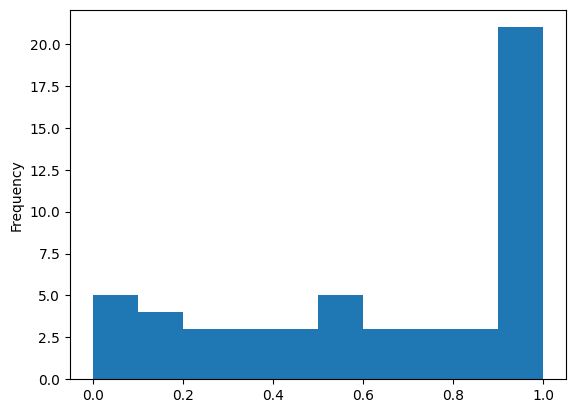

In [73]:
# Create a mapping for the 'connection' column
connection_mapping = {
    x: i for i, x in enumerate(sorted(df['connection'].unique()))
}

# Apply the mapping to create a new 'connection_encoded' column
df['connection_encoded'] = df['connection'].map(connection_mapping)

scaler = MinMaxScaler()
df['connection_scaled'] = scaler.fit_transform(df[['connection_encoded']])
df['connection_scaled'].plot.hist(bins=10)

## 1.3 Location and Keywords

To process the locations:

1. To enhance it, preprocess the location field to standardize formats (e.g., converting "i̇zmir türkiye" to "Izmir, Turkey").
2. Consider clustering similar locations into regions (e.g., "North Carolina Area") to reduce sparsity in embeddings.
3. Use **POS tagging** to ensure proper recognition of city names during Word2Vec embedding creation.

In [74]:
### 1. Preprocess the Location Field to Standardize Formats

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

def standardize_location(location):
    """
    Standardizes location names to "City, Country" format.
    """
    try:
        # Geocode the location
        loc = geolocator.geocode(location, language='en')
        if loc:
            # Extract city and country from the address
            address = loc.address
            address_parts = address.split(', ')
            city = address_parts[0]
            country = address_parts[-1]
            standardized_loc = f"{city}, {country}"
            return standardized_loc
        else:
            return location
    except Exception as e:
        return location

# Apply the standardization function
df['standardized_location'] = df['location'].apply(standardize_location)

**Geocoding Limitations**:
> - **Usage Policies**: The Nominatim service has usage policies and rate limits. It's intended for low-volume, non-commercial use.
- **Caching Results**: For larger datasets or repeated runs, consider caching geocoding results to avoid exceeding rate limits.
- **Alternative Services**: For commercial or high-volume applications, use a geocoding service that allows bulk requests and provides an API key.

In [75]:
### 2. Cluster Similar Locations into Regions

def get_coordinates(location):
    """
    Retrieves latitude and longitude for a given location.
    """
    try:
        loc = geolocator.geocode(location)
        if loc:
            return (loc.latitude, loc.longitude)
        else:
            return np.nan
    except Exception as e:
        return np.nan

# Get coordinates for each standardized location
df['coordinates'] = df['standardized_location'].apply(get_coordinates)

# Drop rows where coordinates could not be found
df.dropna(subset=['coordinates'], inplace=True)

# Extract latitude and longitude into separate columns
df['latitude'] = df['coordinates'].apply(lambda x: x[0])
df['longitude'] = df['coordinates'].apply(lambda x: x[1])

# Prepare data for clustering
coords = df[['latitude', 'longitude']].values

# Determine the number of clusters (you can adjust this number)
num_clusters = 5

# Before performing KMeans clustering, check if coords is empty:
if coords.shape[0] == 0:
    print("Error: No valid coordinates found for clustering. Check your location data.")
    # Handle the case where coords is empty, e.g., skip clustering or assign a default region
    df['region_cluster'] = np.nan  # Assign NaN to region_cluster
    df['region'] = np.nan  # Assign NaN to region
else:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df['region_cluster'] = kmeans.fit_predict(coords)

# Map cluster labels to region names (customize as needed)
region_names = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E'
}
df['region'] = df['region_cluster'].map(region_names)

In [77]:
### 3. Use POS Tagging for Word2Vec Embedding Creation

def extract_proper_nouns(text):
    """
    Extracts proper nouns from text using POS tagging.
    """
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    proper_nouns = [word for word, pos in tagged if pos == 'NNP' or pos == 'NNPS']
    return proper_nouns

# Extract proper nouns from standardized locations
df['location_tokens'] = df['standardized_location'].apply(extract_proper_nouns)

# Prepare sentences for Word2Vec (list of lists of tokens)
sentences = df['location_tokens'].tolist()

# Before training Word2Vec, check if sentences is empty:
if not sentences:
    print("Warning: 'sentences' is empty. Word2Vec model will not be trained.")
    # Handle the case where sentences is empty, e.g., skip Word2Vec or use a pre-trained model
    # For example, you can assign a default embedding:
    df['location_embedding'] = [np.zeros(50)] * len(df)  # Assuming vector_size=50
else:
    # Train the Word2Vec model
    w2v_model = Word2Vec(sentences, vector_size=50, window=3, min_count=1, workers=4)

# Generate location embeddings
def get_location_embedding(tokens):
    """
    Computes the mean Word2Vec embedding for a list of tokens.
    """
    embeddings = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

df['location_embedding'] = df['location_tokens'].apply(get_location_embedding)

# Display the updated DataFrame
display(df[['job_title', 'location', 'standardized_location', 'region', 'location_embedding']].sample(3, random_state=SEED))

,job_title,location,standardized_location,region,location_embedding
14,experienced retail manager aspiring human reso...,"austin, texas area","Area, United States",E,"[-0.000585357, -0.0031810503, 0.0005106212, 0...."
44,student indiana university kokomo business man...,"lafayette, indiana","Lafayette, United States",E,"[-0.010593209, 0.0059779994, 0.0020911486, 0.0..."
13,seeking human resource opportunity,"chicago, illinois","Chicago, United States",A,"[-0.00037678922, 0.00018666654, -6.3825086e-05..."


In [78]:
# Create a map plot of the standardized_location and color by the region. Include only Regions A, B, D and E.

# Filter the DataFrame to include only Regions A, B, D, and E
regions_to_plot = ['A', 'B', 'C', 'D', 'E'] # @param {"type":"raw","placeholder":"['A', 'B', 'C', 'D', 'E']"}
df_filtered = df[df['region'].isin(regions_to_plot)]

# Create the map plot using Plotly Express
fig = px.scatter_geo(
    df_filtered,
    lat='latitude',
    lon='longitude',
    color='region',
    hover_name='standardized_location',  # Display location when hovering
    title='Map of Standardized Locations by Region'
)

fig.update_layout(
    geo=dict(
        scope='world',  # Adjust scope as needed
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitcolor='rgb(255, 255, 255)',
        countrycolor='rgb(255, 255, 255)',
        countrywidth=0.5,
        subunitwidth=0.5
    )
)

fig.show()

## Store the dataset

In [82]:
from pathlib import Path

data_path = Path("data/internim/")
data_path.mkdir(parents=True, exist_ok=True)

df.to_parquet(data_path / "encoded.parquet", index=True)

## Learning to Rank (LTR)

In [ ]:
df.head().to_markdown()

In [ ]:
star_candidate=input("Do you want to star any candidates? Enter 'Yes' or 'No': ")

starred= []
if star_candidate.lower()=="yes":
    starred=[int(item) for item in input("Enter ids of candidates you want to star (separated by space) : ").split()]

In [ ]:
df["starred_score"] =df["BERT_model_fit_score"]
for id_num in starred:
    df.loc[df['id'] == id_num, "starred_score"]=1
df.head()

In [ ]:
import torch
import torch.nn as nn

# Set a seed value
seed_value= 12321

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

In [ ]:
class RankNet(nn.Module):

    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid())

        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out

    def predict(self, input_):
        s = self.model(input_)
        return s

In [ ]:
random_row_1 = df.sample(n=100, replace=True)
random_row_2 =df.sample(n=100, replace=True)
job_title_list_ranknet1 = list(random_row_1["job_title"])
job_title_list_ranknet2 = list(random_row_2["job_title"])
doc_1 =bert_model.encode(job_title_list_ranknet1)
doc_2 =bert_model.encode(job_title_list_ranknet2)
doc_1 =torch.from_numpy(doc_1).float()
doc_2 = torch.from_numpy(doc_2).float()

In [ ]:
y_1 = list(random_row_1['starred_score'])
y_2 = list(random_row_2['starred_score'])
y = torch.tensor([1.0 if y1_i>y2_i else 0.5 if y1_i==y2_i else 0.0 for y1_i, y2_i in zip(y_1, y_2)]).float()

y = y.unsqueeze(1)

In [ ]:
def train_model(optim, lr_list, epoch, patience):
    # track the training loss as the model trains
    losses= []

    model =RankNet(num_feature=768)
    loss_fun= torch.nn.BCELoss()

    for lr in lr_list:
        if optim =="SGD":
            optimizer =torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif optim=="Adam":
            optimizer =torch.optim.Adam(model.parameters(), lr=lr)
        print("lr: ", lr, "optimizer: ", optim)
        epoch = epoch
        train_losses  =[]
        valid_losses = []

        for i in range(1, epoch+1):
            model.zero_grad()
            y_pred =model(doc_1, doc_2)
            loss=loss_fun(y_pred, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if i %100 ==0:
                print("Epoch{}, loss: {}".format(i, loss.item()))

        print("="*100)
    return model, losses

In [ ]:
model, train_loss= train_model(optim="SGD",
                              lr_list=[0.1,0.01,0.001,0.0001,0.00001],
                              epoch=1000,
                              patience=20)

In [ ]:
model, train_loss =train_model(optim="SGD", lr_list=[0.01],
                              epoch=2000,
                              patience=20)

In [ ]:
model, train_loss =train_model(optim="Adam",
                              lr_list=[0.1,0.01,0.001,0.0001,0.00001],
                              epoch=1000,
                              patience=20)

In [ ]:
class RankNet(nn.Module):

    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, num_feature*2),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(num_feature*2, num_feature *4),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(num_feature*4,1),
            nn.Sigmoid())
        self.output_sig =nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 =self.model(input_1)
        s2 =self.model(input_2)
        out =self.output_sig(s1-s2)
        return out

    def predict(self, input_):
        s = self.model(input_)
        return s

In [ ]:
model, train_loss =train_model(optim="SGD",
                              lr_list=[0.01],
                              epoch=2000,
                              patience=20)

In [ ]:
pred_score = []
for i in range(len(df)):
    embedding =bert_model.encode([df["job_title"][i]])
    embedding_tensor = torch.from_numpy(embedding).float()
    pred = round(model.predict(embedding_tensor).detach().numpy().sum(),2)
    pred_score.append(pred)



In [ ]:
df["RankNet_score"] =pred_score
df.sort_values(by="RankNet_score", ascending =False).head()

## CONCLUSION

`BERT` Model was one of the best model to find similarity between our data and the targeted phrase. As for the Ranking Model I ran `RankNet` model on the data and the best Loss score was 48%